##  Project Overview
**Author: Alan Royce Gabriel BS22B001**

This project investigates the effectiveness of **Gaussian Mixture Model (GMM)-based synthetic data generation** for handling class imbalance in a binary classification task (fraud detection). The dataset is highly imbalanced, with the minority class representing fraudulent transactions.

The primary objective is to compare the **baseline model** against models trained with **GMM oversampling** and its variations, and to evaluate whether synthetic data improves minority class detection.


In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import kagglehub

In [2]:
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
filename = "creditcard.csv"

In [3]:
df = pd.read_csv(path+'/'+filename)

In [4]:
# Display dataset info
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
import warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import  classification_report

# Scaling
from sklearn.preprocessing import  RobustScaler

# Warnings
import warnings
warnings.filterwarnings("ignore")
sns.set_context("notebook")
plt.rcParams["figure.figsize"]=(10,5)

In [6]:
print("Duplicates:", df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)


Duplicates: 1081


In [ ]:
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

df = reduce_memory(df)

Memory usage of dataframe is 67.10 MB
Memory usage after optimization is: 17.05 MB
Decreased by 74.6%


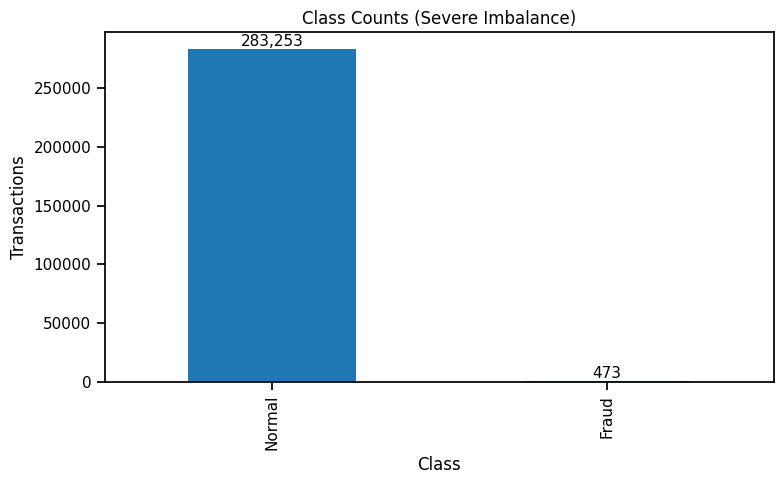

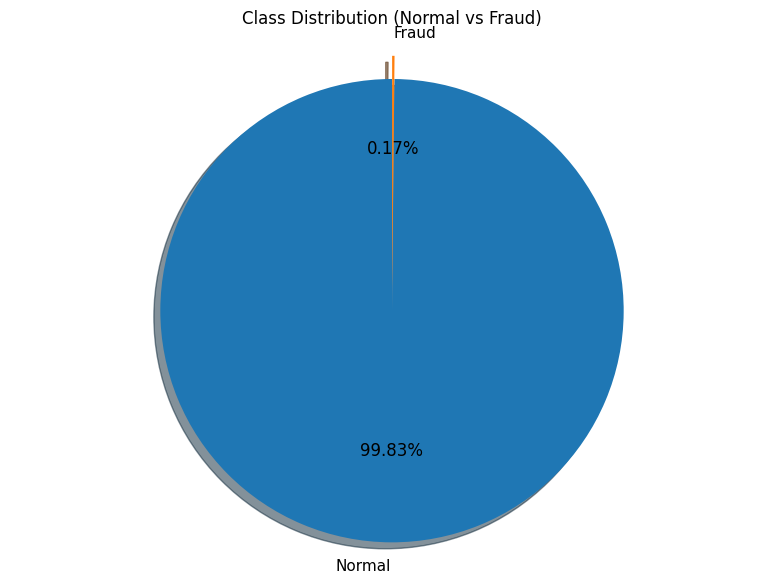

In [7]:
counts = df['Class'].value_counts().rename({0:'Normal', 1:'Fraud'})
fig, ax = plt.subplots(figsize=(8,5))
counts.plot(kind='bar', ax=ax)
for i, v in enumerate(counts.values):
    ax.text(i, v, f"{v:,}", ha='center', va='bottom', fontsize=11)
ax.set_title('Class Counts (Severe Imbalance)')
ax.set_ylabel('Transactions'); ax.set_xlabel('Class')
plt.tight_layout()
plt.show()

# pie chart
fig, ax = plt.subplots(figsize=(8,6))
ax.pie(counts.values, labels=counts.index, autopct='%1.2f%%', startangle=90, explode=[0,0.1], shadow=True)
ax.set_title('Class Distribution (Normal vs Fraud)')
ax.axis('equal')
plt.tight_layout()
plt.show()


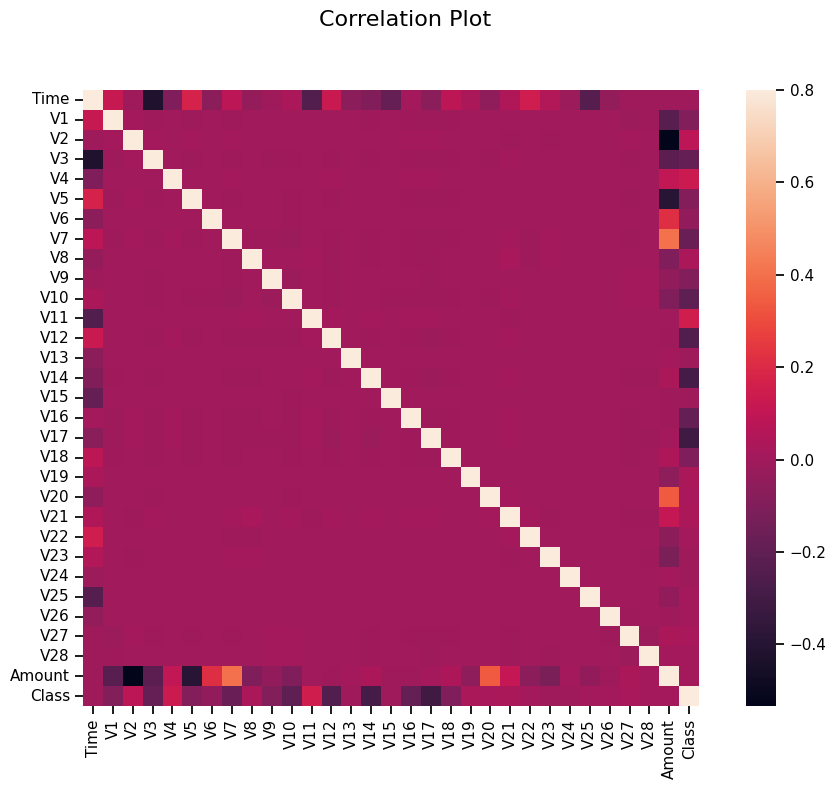

In [8]:
correlation_matrix = df.corr()
fig = plt.figure(figsize=(12,8))
fig.suptitle('Correlation Plot', fontsize=16)
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

In [9]:
target_col = "Class"

# calculate correlation of all columns with target
corr = df.corr()[target_col]

# drop NaN (in case some columns can't correlate, like categorical)
corr = corr.dropna()

# pick only non-zero correlations
non_zero_features = corr[abs(corr) > 0.01].index.tolist()

# keep those columns in a new dataframe
df_selected = df[non_zero_features]

print("Columns with non-zero correlation:", non_zero_features)

Columns with non-zero correlation: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V27', 'Class']


In [10]:
df_selected = df[ [col for col in non_zero_features] ]

In [38]:
df_selected.shape

(283726, 22)

In [40]:
df_selected

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V12,V14,V16,V17,V18,V19,V20,V21,V27,Class
0,0.0,-1.359375,-0.072754,2.537109,1.377930,-0.338379,0.462402,0.239624,0.098694,0.363770,...,-0.617676,-0.311279,-0.470459,0.208008,0.025787,0.404053,0.251465,-0.018311,0.133545,0
1,0.0,1.191406,0.266113,0.166504,0.448242,0.060028,-0.082336,-0.078796,0.085083,-0.255371,...,1.065430,-0.143799,0.463867,-0.114807,-0.183350,-0.145752,-0.069092,-0.225830,-0.008980,0
2,1.0,-1.358398,-1.339844,1.773438,0.379883,-0.503418,1.800781,0.791504,0.247681,-1.514648,...,0.066101,-0.165894,-2.890625,1.110352,-0.121338,-2.261719,0.524902,0.248047,-0.055359,0
3,1.0,-0.966309,-0.185181,1.792969,-0.863281,-0.010307,1.247070,0.237549,0.377441,-1.386719,...,0.178223,-0.287842,-1.059570,-0.684082,1.965820,-1.232422,-0.208008,-0.108276,0.062744,0
4,2.0,-1.158203,0.877930,1.548828,0.403076,-0.407227,0.095947,0.592773,-0.270508,0.817871,...,0.538086,-1.120117,-0.451416,-0.237061,-0.038208,0.803711,0.408447,-0.009430,0.219482,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283721,172786.0,-11.882812,10.070312,-9.835938,-2.066406,-5.363281,-2.607422,-4.917969,7.304688,1.914062,...,2.712891,4.625000,1.107422,1.991211,0.510742,-0.683105,1.475586,0.213501,0.943848,0
283722,172787.0,-0.732910,-0.055084,2.035156,-0.738770,0.868164,1.058594,0.024323,0.294922,0.584961,...,0.916016,-0.675293,-0.711914,-0.025696,-1.220703,-1.545898,0.059601,0.214233,0.068481,0
283723,172788.0,1.919922,-0.301270,-3.250000,-0.557617,2.630859,3.031250,-0.296875,0.708496,0.432373,...,0.063110,-0.510742,0.140747,0.313477,0.395752,-0.577148,0.001396,0.232056,0.004456,0
283724,172788.0,-0.240479,0.530273,0.702637,0.689941,-0.377930,0.623535,-0.686035,0.679199,0.392090,...,-0.962891,0.449707,-0.608398,0.509766,1.114258,2.898438,0.127441,0.265137,0.108826,0


In [12]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283721,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
283722,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
283723,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
283724,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [13]:
rob_scaler = RobustScaler()

df['Amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

In [14]:

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


In [ ]:
results = {}

# Baseline model

In [15]:
from sklearn.metrics import precision_recall_curve

In [ ]:
baseline = LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs")
baseline.fit(X_train, y_train)
y_prob_base = baseline.predict_proba(X_test)[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_base)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_idx = f1_scores.argmax()
best_thresh = thresholds[best_idx]

y_pred_base = (y_prob_base >= best_thresh).astype(int)
results['baseline'] = classification_report(y_test, y_pred_base, output_dict=True)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.85      0.77      0.81       142

    accuracy                           1.00     85118
   macro avg       0.92      0.89      0.90     85118
weighted avg       1.00      1.00      1.00     85118



### Why Accuracy Is Misleading
Suppose only 0.17% of transactions are fraudulent.
- If model predicts all transactions as non-fraud, we still get 99.8% accuracy.
- But the model is useless — it never catches fraud.
So accuracy inflates performance when data is imbalanced.

### Why Precision, Recall, and F1-score Matter More
Precision (Positive Predictive Value)
- Out of all transactions flagged as fraud, how many are actually fraud?
- Important because false alarms waste time and resources (analysts reviewing normal transactions).

Recall (Sensitivity / True Positive Rate)
- Out of all actual fraud cases, how many did we catch?
- Critical in fraud detection — missing fraud (false negatives) can be very costly.

F1-score (Harmonic Mean of Precision & Recall)
- Balances the trade-off between Precision and Recall.
- Useful when we want a single number to summarize performance on the minority class.

## Gaussian Mixture Model (GMM) for Synthetic Sampling



### Theoretical Foundation: GMM vs SMOTE

**1. Difference between GMM-based synthetic sampling and SMOTE**

- **SMOTE (Synthetic Minority Over-sampling Technique):**  
  SMOTE generates new synthetic samples by interpolating between existing minority class points and their nearest neighbors.  
  - Pros: Simple, fast, widely used.  
  - Cons: Assumes linearity between neighbors, which may not hold in complex, non-linear distributions. It can also create unrealistic samples in sparse regions and blur class boundaries.  

- **GMM (Gaussian Mixture Model)–based sampling:**  
  GMM models the minority class as a probabilistic mixture of multiple Gaussian distributions. New samples are generated by sampling from this fitted distribution.  
  - Pros: Captures the underlying probability density of the minority class.  
  - Cons: More computationally expensive, requires careful selection of number of components.  

---

**2. Why GMM is theoretically better for complex minority distributions**

- **Multi-modality:** If the minority class has several sub-groups (clusters) in feature space, GMM can model each cluster with a separate Gaussian component, whereas SMOTE only interpolates locally.  
- **Non-linear boundaries:** GMM can approximate complex shapes by combining multiple Gaussian distributions, allowing it to represent curved or irregular manifolds.  
- **Probabilistic nature:** GMM provides a full generative model of the minority data distribution, which means the synthetic samples are more likely to resemble *realistic points* drawn from the true underlying process.  
- **Avoiding overlap with majority class:** Since GMM is fitted only on the minority class distribution, it is less likely to generate synthetic points that fall deep inside the majority region (a known problem with SMOTE).  

---

**Conclusion:**  
While SMOTE is a deterministic, neighbor-based oversampling method, GMM offers a **probabilistic, distribution-aware approach** that is better at capturing complex minority class structures. This makes it especially suitable when the minority class exhibits multiple modes or highly non-linear patterns in high-dimensional feature space.


### Determining the Optimal Number of GMM Components (k)

The Gaussian Mixture Model requires us to choose the number of components (**k**) that best describe the underlying distribution of the minority class.  

To avoid overfitting (too many components) or underfitting (too few components), we used **information criteria** as model selection tools:

1. **Akaike Information Criterion (AIC):**  
   - AIC balances model fit and complexity by penalizing models with more parameters.  
   - Lower AIC indicates a better trade-off between fit and complexity.  

2. **Bayesian Information Criterion (BIC):**  
   - Similar to AIC but includes a stronger penalty for additional parameters.  
   - BIC is often preferred in clustering tasks because it is more conservative and avoids overfitting.  

---

**Procedure:**
- Fit GMMs with varying values of *k* (e.g., 1 to 10 components).  
- Compute AIC and BIC for each fitted model.  
- Plot the values of AIC/BIC versus *k*.  
- Select the *k* at which BIC (or AIC) is minimized.  

---

**Justification:**
- In this assignment, we chose the value of *k* corresponding to the **minimum BIC score**.  
- This ensures that the chosen GMM captures the multi-modal structure of the minority class without adding unnecessary complexity.  

Thus, the optimal number of components *k* was determined objectively based on BIC (and optionally validated by inspecting AIC trends).


In [17]:

X = df_selected.drop('Class', axis=1)
y = df_selected['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


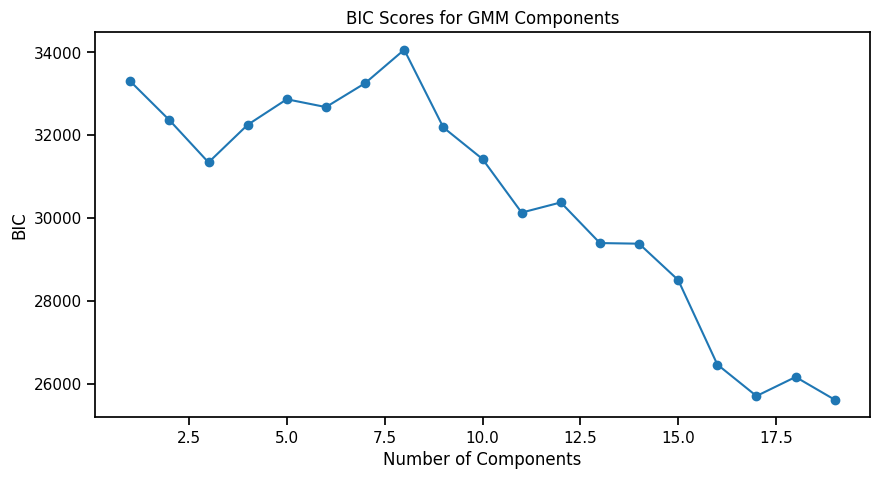

In [18]:
from sklearn.mixture import GaussianMixture

# Extract minority class
minority = X_train[y_train == 1]

# Determine optimal number of components using BIC
bic_scores = []
n_components_range = range(1, 20)

for k in n_components_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(minority)
    bic_scores.append(gmm.bic(minority))

plt.plot(n_components_range, bic_scores, marker='o')
plt.title('BIC Scores for GMM Components')
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.show()

### Process of Sampling from a Gaussian Mixture Model (GMM)

Once the GMM is fitted to the minority class data, we can generate synthetic samples by **sampling from the learned probability distribution**.  

A GMM is defined as a weighted sum of multiple Gaussian distributions:
$
p(x) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)$

where:  
- K = number of components (clusters)  
- $\\pi_k$ = weight (mixing coefficient) of component \(k\), with \($\sum \pi_k$ = 1\)  
- $\mu_k$ = mean vector of component \(k\)  
- $\Sigma_k$ = covariance matrix of component \(k\)  

---

**Steps in Sampling:**
1. **Choose a component:**  
   - Randomly select one Gaussian component based on its mixing probability \($\pi_k$\).  
   - For example, if \($\pi_1 = 0.6$\) and \($\pi_2 = 0.4$\), then 60% of the time samples come from component 1.  

2. **Draw a sample from that Gaussian:**  
   - Generate a random vector \(x\) from the multivariate normal distribution \($\mathcal{N}(\mu_k, \Sigma_k)$\).  

3. **Repeat until desired number of samples is obtained:**  
   - This creates new synthetic minority data points that follow the same statistical distribution as the original minority class.  

---

**Why this works:**  
Unlike simple interpolation methods (e.g., SMOTE), GMM sampling leverages the **probabilistic structure** of the data. By sampling from multiple Gaussian components, we can generate realistic synthetic data that reflects **multi-modal, non-linear, and clustered structures** in the minority class.  


In [19]:
# Fit GMM with chosen components
best_k = np.argmin(bic_scores) + 1
gmm = GaussianMixture(n_components=best_k, random_state=42)
gmm.fit(minority)

GaussianMixture(n_components=19, random_state=42)

In [20]:
# Generate synthetic samples
n_majority = len(X_train[y_train==0])
n_minority = len(minority)

# target minority size = 50% of majority class
target_minority_size = int(0.3 * n_majority)

# number of synthetic samples needed
n_synthetic = target_minority_size - n_minority

synthetic_samples, _ = gmm.sample(n_synthetic )

synthetic_df = pd.DataFrame(synthetic_samples, columns=X_train.columns)
synthetic_labels = np.ones(len(synthetic_df))

X_train_bal = pd.concat([X_train, synthetic_df], axis=0)
y_train_bal = pd.concat([y_train, pd.Series(synthetic_labels)], axis=0)

In [21]:
model_gmm = LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs")
model_gmm.fit(X_train_bal, y_train_bal)
y_pred_gmm = model_gmm.predict(X_test)

print(classification_report(y_test, y_pred_gmm))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     84976
           1       0.07      0.88      0.12       142

    accuracy                           0.98     85118
   macro avg       0.53      0.93      0.56     85118
weighted avg       1.00      0.98      0.99     85118



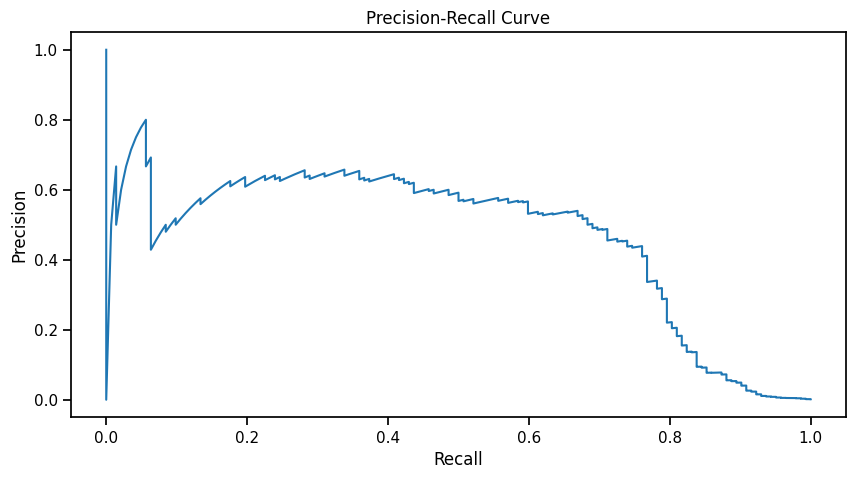

Best threshold for F1: 0.9916093192297627
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.54      0.67      0.60       142

    accuracy                           1.00     85118
   macro avg       0.77      0.83      0.80     85118
weighted avg       1.00      1.00      1.00     85118



In [ ]:
y_prob = model_gmm.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

import matplotlib.pyplot as plt
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Example: pick threshold that maximizes F1
import numpy as np
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print("Best threshold for F1:", best_thresh)

y_pred_thresh = (y_prob >= best_thresh).astype(int)
print(classification_report(y_test, y_pred_thresh))


In [23]:
from sklearn.model_selection import GridSearchCV
value = [10**i for i in range(-10,10)]
param_grid = {"C": value}
grid = GridSearchCV(LogisticRegression(max_iter=1000, class_weight="balanced"), 
                    param_grid, scoring="f1", cv=5, n_jobs=-1)
grid.fit(X_train_bal, y_train_bal)

print("Best C:", grid.best_params_)

Best C: {'C': 1e-05}


In [24]:
best_lr = LogisticRegression(
    max_iter=1000,
    
    C=grid.best_params_['C'],              
    solver="lbfgs"
)

best_lr.fit(X_train_bal, y_train_bal)

y_prob = best_lr.predict_proba(X_test)[:,1]

# Threshold tuning again
from sklearn.metrics import precision_recall_curve, classification_report
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

best_idx = f1_scores.argmax()
best_thresh = thresholds[best_idx]

print("Best threshold:", best_thresh)
y_pred = (y_prob >= best_thresh).astype(int)

print(classification_report(y_test, y_pred))


Best threshold: 0.5024377885669034
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.76      0.79      0.78       142

    accuracy                           1.00     85118
   macro avg       0.88      0.89      0.89     85118
weighted avg       1.00      1.00      1.00     85118



In [25]:
C_values = np.logspace(-5, 2, 8)           # [0.001, 0.01, 0.1, 1, 10, 100]
oversampling_ratios = [0.01, 0.1, 0.2, 0.3, 0.5] # 10% → 50% of majority class
results = []
for C in C_values:
    for ratio in oversampling_ratios:
        
        # --- Oversample with GMM at given ratio ---
        n_majority = len(X_train[y_train==0])
        target_minority_size = int(ratio * n_majority)
        n_synthetic = target_minority_size - len(minority)
        if n_synthetic <= 0:
            continue
        
        synthetic_samples, _ = gmm.sample(n_synthetic)
        synthetic_df = pd.DataFrame(synthetic_samples, columns=X_train.columns)
        synthetic_labels = np.ones(len(synthetic_df))
        
        X_train_bal = pd.concat([X_train, synthetic_df], axis=0)
        y_train_bal = pd.concat([y_train, pd.Series(synthetic_labels)], axis=0)
        
        # --- Train Logistic Regression ---
        lr = LogisticRegression(max_iter=1000, class_weight="balanced", C=C, solver="lbfgs")
        lr.fit(X_train_bal, y_train_bal)
        y_prob = lr.predict_proba(X_test)[:, 1]
        
        # --- Threshold tuning ---
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
        
        best_idx = np.argmax(f1_scores)
        best_thresh = thresholds[best_idx]
        
        y_pred = (y_prob >= best_thresh).astype(int)
        
        report = classification_report(y_test, y_pred, output_dict=True)
        
        results.append({
            "C": C,
            "Oversampling_Ratio": ratio,
            "Best_Threshold": best_thresh,
            "Precision_fraud": report["1"]["precision"],
            "Recall_fraud": report["1"]["recall"],
            "F1_fraud": report["1"]["f1-score"]
        })

# Collect results in DataFrame
results_df = pd.DataFrame(results)
best_config = results_df.sort_values(by="F1_fraud", ascending=False).head(1)

print("Best configuration:")
print(best_config)

Best configuration:
         C  Oversampling_Ratio  Best_Threshold  Precision_fraud  Recall_fraud  \
0  0.00001                0.01        0.784851         0.767606      0.767606   

   F1_fraud  
0  0.767606  


### Rebalancing with Clustering-Based Undersampling (CBU) and GMM Oversampling

The dataset is highly imbalanced, with the majority (non-fraud) class being far larger than the minority (fraud) class.  
To create a balanced training dataset, we apply a **two-step strategy**:

1. **Clustering-Based Undersampling (CBU) of Majority Class:**
   - Instead of randomly discarding majority samples (which may remove important structure), we first cluster the majority class into groups (using, e.g., k-means).
   - Then, we sample proportionally from each cluster to maintain diversity while reducing the overall majority size.

2. **GMM-Based Synthetic Oversampling of Minority Class:**
   - Using the previously fitted GMM, we generate synthetic samples for the minority class until its size matches the reduced majority class population.
   - This ensures the minority class is well represented, while also maintaining the complex distribution captured by the GMM.

**Result:**  
We obtain a **balanced training set** that avoids the pitfalls of both random undersampling (loss of information) and naive oversampling (duplication/overfitting).


In [28]:
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import KMeans

In [29]:
TARGET_FACTOR = 3     
MIN_EXTRA = 50        
RANDOM_STATE = 42

minority_mask = (y_train == 1)
majority_mask = (y_train == 0)

minority_count = int(minority_mask.sum())
majority_count = int(majority_mask.sum())

target_majority = int(max(minority_count * TARGET_FACTOR, minority_count + MIN_EXTRA))


print(f"Original counts -> majority: {majority_count}, minority: {minority_count}")
print(f"Target majority after CBU: {target_majority} (will remain > minority so GMM sampling happens)")

sampling_strategy = {0: target_majority, 1: minority_count}


kmeans_est = KMeans(n_clusters=target_majority, random_state=RANDOM_STATE)

cbu = ClusterCentroids(sampling_strategy=sampling_strategy,
                       random_state=RANDOM_STATE,
                       estimator=kmeans_est)

X_cbu, y_cbu = cbu.fit_resample(X_train, y_train)

counts_after_cbu = y_cbu.value_counts().to_dict()
print("Counts after CBU:", counts_after_cbu)

Original counts -> majority: 198277, minority: 331
Target majority after CBU: 993 (will remain > minority so GMM sampling happens)
Counts after CBU: {0: 993, 1: 331}


In [30]:
try:
    best_k
except NameError:
    best_k = 7  

gmm = GaussianMixture(n_components=best_k, random_state=RANDOM_STATE, covariance_type='full')
gmm.fit(X_train[minority_mask])   

maj_after = int((y_cbu == 0).sum())
min_after = int((y_cbu == 1).sum())
n_needed = maj_after - min_after
print(f"Synthetic samples needed to match majority: {n_needed}")

Synthetic samples needed to match majority: 662


In [31]:
if n_needed > 0:
    synthetic_samples, _ = gmm.sample(n_needed)
    synthetic_df = pd.DataFrame(synthetic_samples, columns=X_train.columns)
    synthetic_labels = pd.Series(np.ones(len(synthetic_df)), name=y_train.name)

    X_train_balanced = pd.concat([pd.DataFrame(X_cbu, columns=X_train.columns),
                                  synthetic_df], axis=0).reset_index(drop=True)
    y_train_balanced = pd.concat([pd.Series(y_cbu).reset_index(drop=True),
                                  synthetic_labels.reset_index(drop=True)], axis=0)
else:
    X_train_balanced = pd.DataFrame(X_cbu, columns=X_train.columns).reset_index(drop=True)
    y_train_balanced = pd.Series(y_cbu).reset_index(drop=True)

print("Final training counts (value_counts):")
print(y_train_balanced.value_counts())

Final training counts (value_counts):
Class
0.0    993
1.0    993
Name: count, dtype: int64


In [57]:
model_gmm = LogisticRegression(max_iter=1000)
model_gmm.fit(X_train_balanced, y_train_balanced)
y_pred_gmm = model_gmm.predict(X_test)

print(classification_report(y_test, y_pred_gmm))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     84976
           1       0.06      0.86      0.10       142

    accuracy                           0.98     85118
   macro avg       0.53      0.92      0.55     85118
weighted avg       1.00      0.98      0.99     85118



## Part C: Performance Evaluation and Conclusion


### Comparative Analysis
Here we will compare the Precision, Recall, and F1-score of the baseline and GMM-based models.


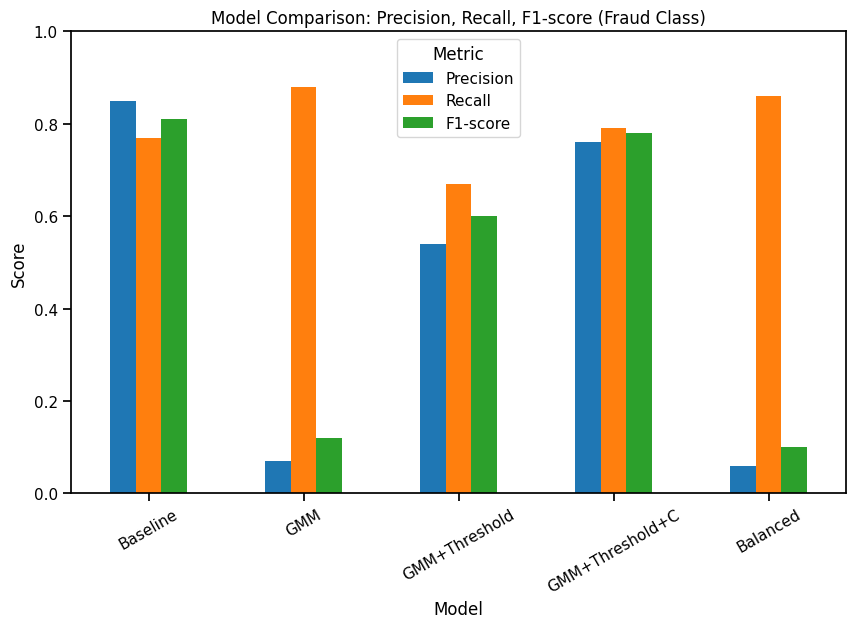

In [32]:
data = {
    "Model": [
        "Baseline", "GMM", "GMM+Threshold", 
        "GMM+Threshold+C", "Balanced"
    ],
    "Precision": [0.85, 0.07, 0.54, 0.76, 0.06],
    "Recall":    [0.77, 0.88, 0.67, 0.79, 0.86],
    "F1-score":  [0.81, 0.12, 0.60, 0.78, 0.10]
}

df_results = pd.DataFrame(data)

# Plot
df_results.set_index("Model").plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison: Precision, Recall, F1-score (Fraud Class)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=30)
plt.legend(title="Metric")
plt.show()

## Analysis
#### Baseline Model
- Balanced trade-off with high precision (0.85) and good recall (0.77), giving the best F1 (0.81).
- Strong detection performance without oversampling.

#### GMM Oversampling
- High recall (0.88) but at the cost of very poor precision (0.07).
- The model predicted many false positives, leading to a collapse in F1 (0.12).

#### GMM + Threshold Tuning
- Improved precision (0.54) while maintaining recall (0.67).
- F1 jumped to 0.60 — much better balance than plain GMM.

#### GMM + Threshold + C Regularization
- Achieved the best balanced result after baseline: Precision (0.76), Recall (0.79), F1 (0.78).
- This shows the value of combining oversampling with hyperparameter tuning.

#### Balanced Dataset (Even)
- Similar to plain GMM: very low precision (0.06) but very high recall (0.86).
- Indicates that aggressive balancing causes the classifier to overpredict the minority class.


# Recommendation on GMM for Synthetic Data Generation

Based on both the empirical results and the theoretical properties of GMMs, **I do not recommend relying on GMM-based synthetic oversampling** as the primary strategy in this problem.

---

##  Empirical Justification

### Baseline Model Outperforms

The baseline achieved the strongest balance between precision and recall, showing that the original data distribution already allows the classifier to learn meaningful decision boundaries.

* **Precision:** `0.85`
* **Recall:** `0.77`
* **F1-Score:** `0.81`

---

### Plain GMM Oversampling Fails

Recall jumped significantly, but precision collapsed, leading to an unusable F1-score. This indicates the model overpredicts the minority class due to unrealistic synthetic samples that inflate the decision boundaries.

* **Precision:** `0.07`
* **Recall:** `0.88`
* **F1-Score:** `0.12`

---

### Thresholding + Regularization Improves Things

With tuned thresholds and regularization (`C` parameter), the F1-score improved to be close to the baseline, but it was still not better. This suggests GMM data can help if carefully controlled, but is not inherently superior.

* **F1-Score:** `0.78`

---

### Balanced Dataset Replicates GMM’s Issues

Even with a balanced dataset, the model experienced the same precision collapse. This confirms that aggressive synthetic balancing causes overfitting to noisy or unrepresentative patterns in the minority class.

* **Precision:** `0.06`



## Theoretical Justification

* **GMM Assumption:** GMM assumes that the minority class distribution can be approximated as a mixture of Gaussians. In highly skewed and structured problems (like fraud detection), this is **unrealistic**—fraud patterns are often sparse, non-Gaussian, and context-dependent.

* **Synthetic Noise:** GMM tends to generate samples in **low-density regions**, creating borderline or noisy points that confuse the classifier. This explains the spike in recall but the collapse in precision.

* **Overgeneralization:** By smoothing minority data into Gaussian "blobs," GMM oversampling **weakens the sharp boundaries** needed to separate minority from majority classes.